In [4]:
import pandas as pd
import numpy as np 
import yaml
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

Reading data

In [5]:
df = pd.read_csv("Data/index_archieve/security.csv", skiprows=2, encoding='cp1251', sep=";")

In [6]:
with open("config.yaml", 'r') as option_file:
    options = yaml.safe_load(option_file)

Preprocessing

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5489 entries, 0 to 5488
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   BOARDID         5489 non-null   object 
 1   SECID           5489 non-null   object 
 2   TRADEDATE       5489 non-null   object 
 3   SHORTNAME       5489 non-null   object 
 4   NAME            5489 non-null   object 
 5   CLOSE           5489 non-null   object 
 6   OPEN            5254 non-null   object 
 7   HIGH            5263 non-null   object 
 8   LOW             5263 non-null   object 
 9   VALUE           5263 non-null   object 
 10  DURATION        1517 non-null   float64
 11  YIELD           1517 non-null   float64
 12  DECIMALS        5489 non-null   int64  
 13  CAPITALIZATION  3014 non-null   object 
 14  CURRENCYID      5489 non-null   object 
 15  DIVISOR         2554 non-null   object 
 16  TRADINGSESSION  5489 non-null   int64  
 17  VOLUME          0 non-null      f

In [8]:
df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'], format='%d.%m.%Y')
df.set_index('TRADEDATE', inplace=True)
df[['OPEN', 'CLOSE', 'HIGH', 'LOW', 'VALUE']] = df[['OPEN', 'CLOSE', 'HIGH', 'LOW', 'VALUE']].apply(lambda x: x.str.replace(',', '.').astype(float))

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5489 entries, 2002-01-03 to 2023-12-20
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   BOARDID         5489 non-null   object 
 1   SECID           5489 non-null   object 
 2   SHORTNAME       5489 non-null   object 
 3   NAME            5489 non-null   object 
 4   CLOSE           5489 non-null   float64
 5   OPEN            5254 non-null   float64
 6   HIGH            5263 non-null   float64
 7   LOW             5263 non-null   float64
 8   VALUE           5263 non-null   float64
 9   DURATION        1517 non-null   float64
 10  YIELD           1517 non-null   float64
 11  DECIMALS        5489 non-null   int64  
 12  CAPITALIZATION  3014 non-null   object 
 13  CURRENCYID      5489 non-null   object 
 14  DIVISOR         2554 non-null   object 
 15  TRADINGSESSION  5489 non-null   int64  
 16  VOLUME          0 non-null      float64
dtypes: float64(8), 

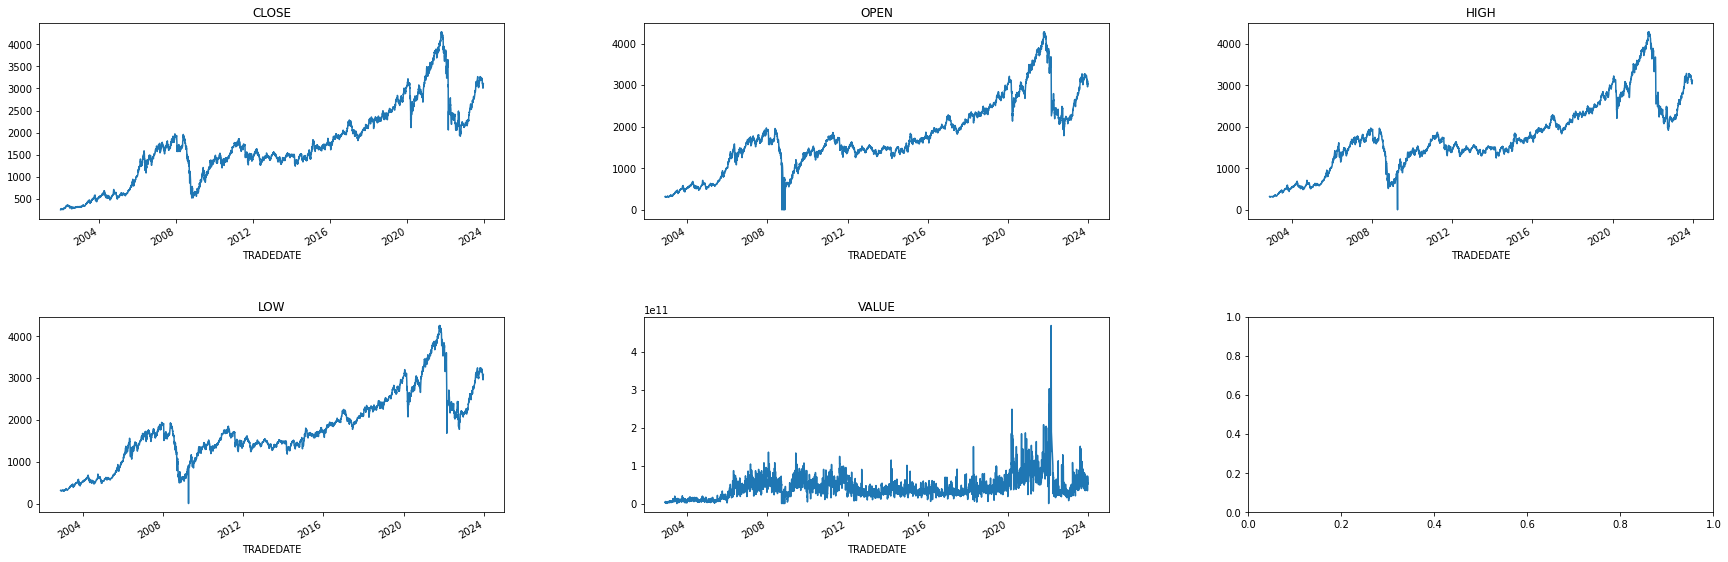

In [9]:
columns_to_plot = ['CLOSE', 'OPEN', 'HIGH', 'LOW', 'VALUE']

fig, axes = plt.subplots(nrows=len(columns_to_plot)//2, ncols=3, figsize=(30, 2 * len(columns_to_plot)))

for i, column in enumerate(columns_to_plot):
    df[column].plot(ax=axes[i//3][i%3], label=column)
    axes[i//3][i%3].set_title(column)
    fig.subplots_adjust(hspace=0.5, wspace=0.3)

plt.show()

In [10]:
df.CLOSE

TRADEDATE
2002-01-03     246.79
2002-01-04     256.98
2002-01-08     268.01
2002-01-09     268.30
2002-01-10     265.38
               ...   
2023-12-14    3008.84
2023-12-15    3033.89
2023-12-18    3076.26
2023-12-19    3083.64
2023-12-20    3104.66
Name: CLOSE, Length: 5489, dtype: float64

In [11]:
numeric_columns = df.select_dtypes(include=[np.number])
df = numeric_columns.resample('M').mean()
df.head(5)

,CLOSE,OPEN,HIGH,LOW,VALUE,DURATION,YIELD,DECIMALS,TRADINGSESSION,VOLUME
TRADEDATE,,,,,,,,,,
2002-01-31,261.968000,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,NaN
2002-02-28,261.784211,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,NaN
2002-03-31,285.944500,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,NaN
2002-04-30,322.336087,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,NaN
2002-05-31,341.772222,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,NaN


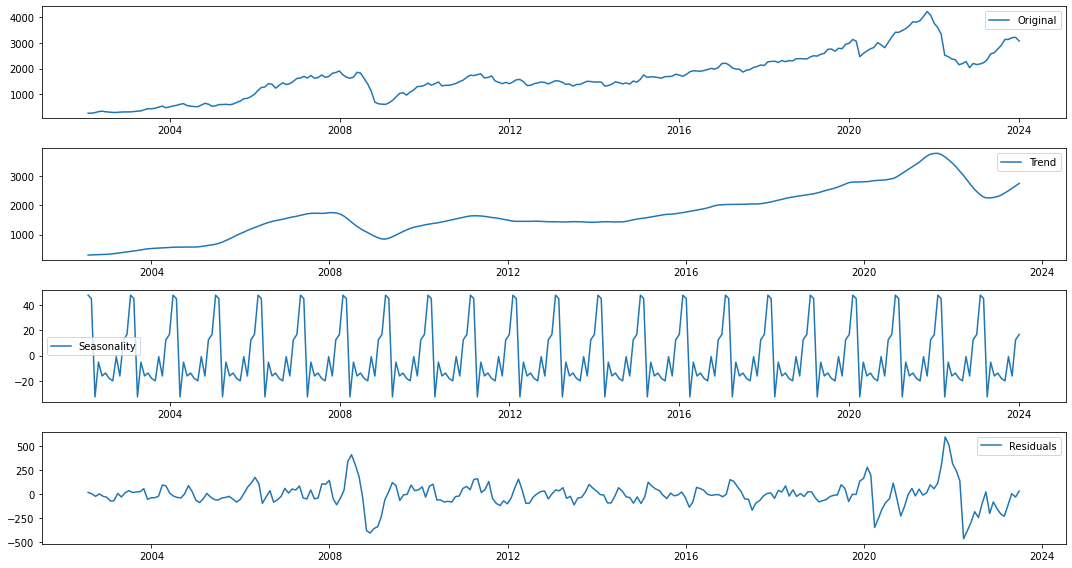

In [12]:
result = seasonal_decompose(df.CLOSE, model='additive')

plt.figure(figsize=(15, 8))

plt.subplot(411)
plt.plot(df.CLOSE, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(result.resid, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

Подбор гиперпараметров для модели

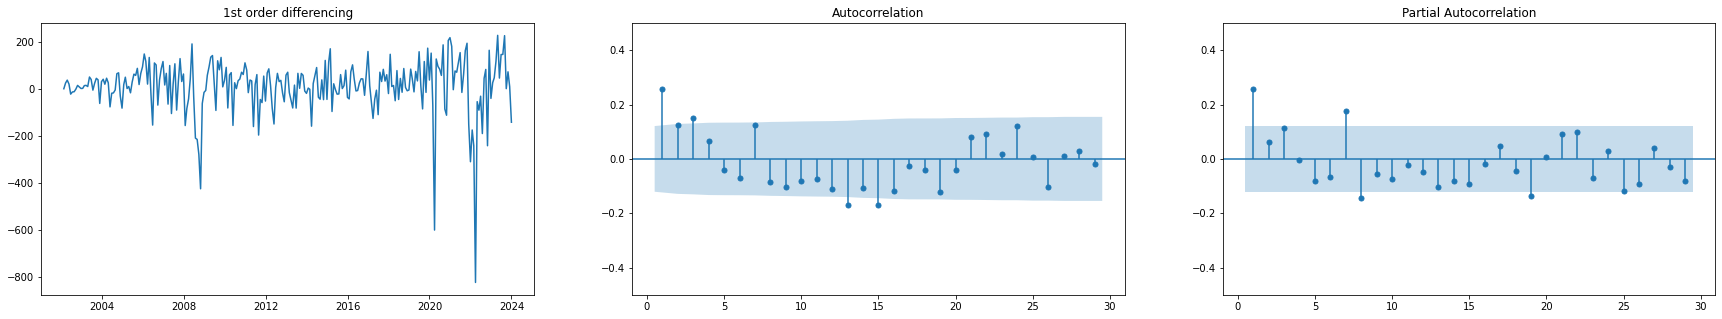

ADF Statistic: -5.451100006149583
p-value: 2.6432895046376077e-06
Critical Values: {'1%': -3.4562572510874396, '5%': -2.8729420379793598, '10%': -2.5728461399461744}
Is the time series stationary? True


In [13]:
# Проверка стационарности временного ряда через критерий Дики-Фуллера
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    print('Is the time series stationary?', result[1] < 0.05)

fig = plt.figure(figsize=(30, 5))

ax1 = fig.add_subplot(131)
ax1.set_title('1st order differencing')
ax1.plot(df.CLOSE.diff().dropna()) 

ax2 = fig.add_subplot(132)
plot_acf(df.CLOSE.diff().dropna(), lags=[i for i in range(1, 30)], ax=ax2)
ax2.set_ylim(-0.5, 0.5)

ax3 = fig.add_subplot(133)
plot_pacf(df.CLOSE.diff().dropna(), lags=[i for i in range(1, 30)], ax=ax3)
ax3.set_ylim(-0.5, 0.5)
plt.show()


test_stationarity(df.CLOSE.diff().dropna())

Model 

In [14]:
len(df)

264

Значение p выбирается на основе последней значимой лаги в PACF, в то время как значение q выбирается на основе последней значимой лаги в ACF.

p - по количеству статистически значимых частичных автокорреляций

d - количество дифференцирований для стационарности ряда, которое определяется через критерий Дики Фуллера 

q - определяется по количеству статистически значимых значений автокорреляции с графика ACF 

In [22]:
with open("config.yaml", 'r') as option_file:
    options = yaml.safe_load(option_file)

p = options['p']
d = options['d']
q = options['q']

In [23]:
months_to_predict = options['months_to_predict']

model = ARIMA(df.CLOSE[:-months_to_predict], order=(p, d, q))  # (p, d, q)

model_fit = model.fit()

print(model_fit.summary())

forecast = model_fit.forecast(steps=months_to_predict) 
print(forecast)

                               SARIMAX Results                                
Dep. Variable:                  CLOSE   No. Observations:                  252
Model:                ARIMA(19, 2, 3)   Log Likelihood               -1513.197
Date:                Wed, 10 Jan 2024   AIC                           3072.393
Time:                        19:13:30   BIC                           3153.387
Sample:                    01-31-2002   HQIC                          3104.991
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1261      0.505      2.229      0.026       0.136       2.116
ar.L2         -0.7943      0.416     -1.911      0.056      -1.609       0.020
ar.L3          0.2138      0.140      1.524      0.1

c:\Users\pasin\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


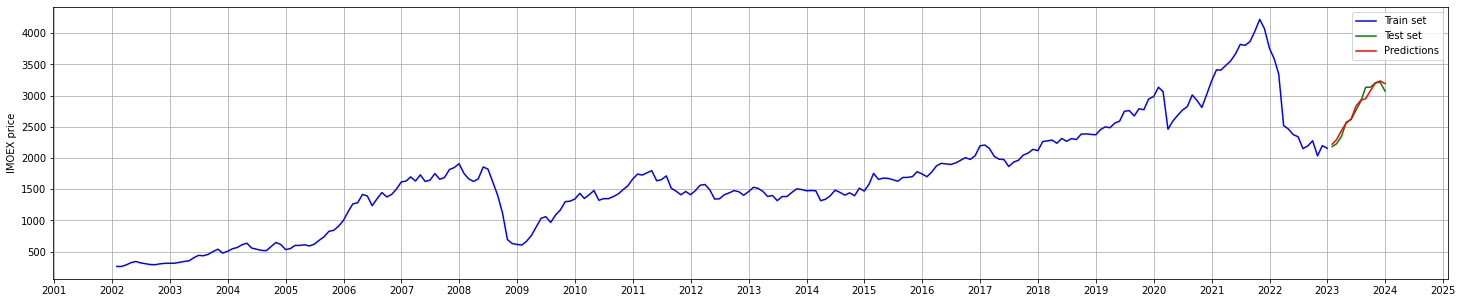


---METRICS---

Mean Absolute Error (MAE):  56.544990770359426
R-squared:  0.9573233601771023
Mean Absolute Percentage Error (MAPE):  0.020460745600584657


In [24]:
def plot_graphs(forecast, months_to_predict):
    # plot
    plt.figure(figsize=(25, 5))

    plt.plot(df.index[:-months_to_predict], df.CLOSE[:-months_to_predict], label = "Train set", color = "b") 
    plt.plot(df.index[-months_to_predict:], df.CLOSE[-months_to_predict:], label = "Test set", color = "g") 
    plt.plot(df.index[-months_to_predict:], forecast, label = "Predictions", color = "r")    

    plt.ticklabel_format(axis='y', style='plain')
    plt.grid(True) 
    plt.legend()
    plt.ylabel("IMOEX price")
    years = YearLocator()
    plt.gca().xaxis.set_major_locator(years)
    
    plt.show()
    
    # metrics
    actual_data = df.CLOSE[-months_to_predict:]
    print("\n---METRICS---\n")
    print("Mean Absolute Error (MAE): ", mean_absolute_error(actual_data, forecast))
    print("R-squared: ", r2_score(actual_data, forecast))
    print("Mean Absolute Percentage Error (MAPE): ", mean_absolute_percentage_error(actual_data, forecast))

plot_graphs(forecast, months_to_predict)

Predictions

In [31]:
months_to_predict = options['months_to_predict']

model = ARIMA(df.CLOSE, order=(p, d, q))  # (p, d, q)

model_fit = model.fit()

print(model_fit.summary())

forecast = model_fit.forecast(steps=months_to_predict) 
print(forecast)

c:\Users\pasin\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  CLOSE   No. Observations:                  264
Model:                ARIMA(19, 2, 3)   Log Likelihood               -1583.038
Date:                Fri, 12 Jan 2024   AIC                           3212.076
Time:                        18:58:20   BIC                           3294.148
Sample:                    01-31-2002   HQIC                          3245.063
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0214      0.120      8.482      0.000       0.785       1.257
ar.L2         -1.0152      0.153     -6.637      0.000      -1.315      -0.715
ar.L3          0.2808      0.126      2.229      0.0

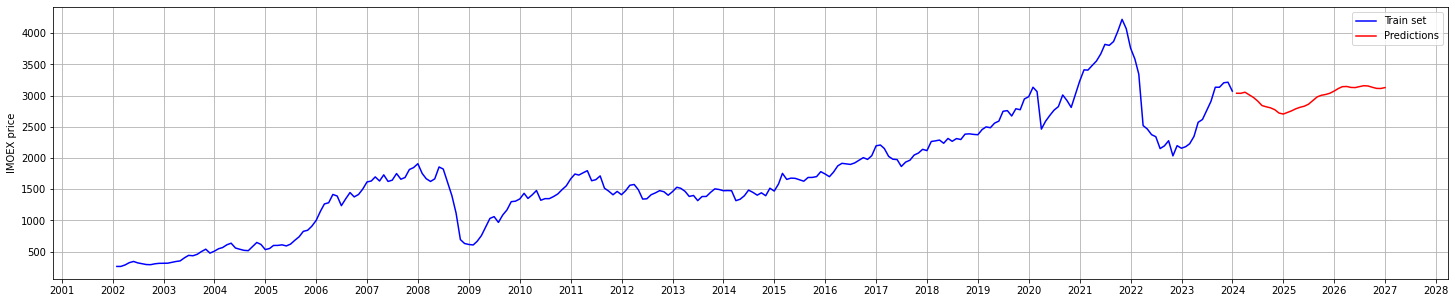


---METRICS---

Mean Absolute Error (MAE):  641.4433938492026
R-squared:  -0.24600999935656098
Mean Absolute Percentage Error (MAPE):  0.2224983822253921


In [32]:
def plot_graphs(forecast, months_to_predict):
    # plot
    plt.figure(figsize=(25, 5))

    plt.plot(df.index, df.CLOSE, label = "Train set", color = "b") 
    plt.plot(forecast, label = "Predictions", color = "r")    

    plt.ticklabel_format(axis='y', style='plain')
    plt.grid(True) 
    plt.legend()
    plt.ylabel("IMOEX price")
    years = YearLocator()
    plt.gca().xaxis.set_major_locator(years)
    
    plt.show()
    
    # metrics
    actual_data = df.CLOSE[-months_to_predict:]
    print("\n---METRICS---\n")
    print("Mean Absolute Error (MAE): ", mean_absolute_error(actual_data, forecast))
    print("R-squared: ", r2_score(actual_data, forecast))
    print("Mean Absolute Percentage Error (MAPE): ", mean_absolute_percentage_error(actual_data, forecast))

plot_graphs(forecast, months_to_predict)

Дополнение

<AxesSubplot: xlabel='TRADEDATE'>

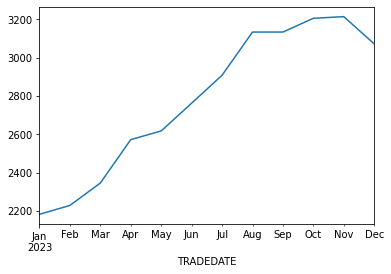

In [55]:
df.CLOSE[-months_to_predict:].plot()

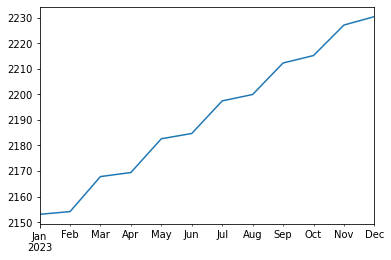

In [139]:
plt.ticklabel_format(useOffset=False)
forecast.plot()
plt.show()